<a href="https://colab.research.google.com/github/wayoo2019/Competitions/blob/main/Travelers_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project uses data from 2021 Travelers Modeling Competition (https://www.kaggle.com/c/2021-travelers-modeling-competition). I use LGBM+XGBoost with Random oversampling method and soft voting to improve f1 score for the minority group from 0.08 to 0.392 (rank 8th out 40 teams from 6 universities). My Feature engineering does not help for score improvement which may because of lacking of domain knowledge.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import libraries

In [ ]:
# !pip install catboost

In [51]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter

#models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier 
from sklearn.ensemble import IsolationForest

#metrix, encoding, spliting
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix

# sampling methods
from imblearn.over_sampling import RandomOverSampler,SMOTE,SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced


#Ensemble methods
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier


import time
import warnings
import gc


import datetime

pd.set_option('display.max_columns', None)
# plt.style.use(style = 'seaborn')

warnings.filterwarnings('ignore')

Import Original Data

In [21]:
%%time
train = pd.read_csv("/content/drive/MyDrive/2021-travelers-modeling-competition/train_2021.csv")
test = pd.read_csv("/content/drive/MyDrive/2021-travelers-modeling-competition/test_2021.csv")

CPU times: user 69.8 ms, sys: 21.8 ms, total: 91.6 ms
Wall time: 108 ms


In [22]:
cat_cols = train.select_dtypes(include=['object', 'category']).columns.to_list()
cat_cols

['gender',
 'living_status',
 'claim_date',
 'claim_day_of_week',
 'accident_site',
 'channel',
 'vehicle_category',
 'vehicle_color']

## 1. Missing value imputation

Create missing count for each row/sample

In [23]:
train['mis_count'] = train.isnull().sum(axis=1)
test['mis_count'] = test.isnull().sum(axis=1)

Impute -1 for the missing values of binary features

In [24]:
train.loc[(train['witness_present_ind'].isnull()), 'witness_present_ind'] = -1
test.loc[(test['witness_present_ind'].isnull()), 'witness_present_ind'] = -1

In [25]:
train.loc[(train['marital_status'].isnull()), 'marital_status'] = -1
test.loc[(test['marital_status'].isnull()), 'marital_status'] = -1

Impute median or min for the missing value of continupous features 

In [26]:
train.loc[(train['age_of_vehicle'].isnull()), 'age_of_vehicle'] = train['age_of_vehicle'].median()
test.loc[(test['age_of_vehicle'].isnull()), 'age_of_vehicle'] = test['age_of_vehicle'].median()

In [27]:
train.loc[(train['claim_est_payout'].isnull()), 'claim_est_payout'] = train['claim_est_payout'].min()
test.loc[(test['claim_est_payout'].isnull()), 'claim_est_payout'] = test['claim_est_payout'].min()

##2. Preliminary model selection 

Since this is a kaggle competition, the candidats models are LightGBM, XGboost, CatBoost

In [28]:
#XGB
clf_xgb = XGBClassifier()
#LGBM
clf_lgb = LGBMClassifier()
#CatBoost
clf_cat = CatBoostClassifier(verbose=False)

def model_score(X, y):
  Classifiers = ['XGboost','LightGBM','CatBoost']
  scores = []
  models = [clf_xgb, clf_lgb, clf_cat]

  cv_split = ShuffleSplit(n_splits = 5, test_size = .2, train_size = .8, random_state = 0 )

  for model in models:
    score = cross_val_score(model, X, y, scoring="f1", cv=cv_split).mean()
    scores.append(score)

  results = pd.DataFrame(scores, index=Classifiers, columns=["Score"]).sort_values(by = 'Score', ascending = False)

  print(results)


Convert categorical features to numerical features before running models

In [29]:
def cat2num (cols_list):
  for col in cols_list:
    le = LabelEncoder()
    le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
    train[col] = le.transform(list(train[col].astype(str).values))
    test[col] = le.transform(list(test[col].astype(str).values))

In [30]:
cols_list = train.select_dtypes(include=['object', 'category']).columns.tolist()
cat2num(cols_list)

In [31]:
X, y = train.drop(columns='fraud', axis=1), train.fraud
# X = X.drop(columns='claim_number', axis=1)

In [32]:
model_score(X, y)

             Score
LightGBM  0.086131
CatBoost  0.082393
XGboost   0.048326


F1_score is binary which reports only the positive lable score. Actually, that is what competition looking for. All thress models have bad results, and the relative better model is LGBM. Since this is skewed data, so sampling method will be considered to improve the score.

In [33]:
train['fraud'].mean()

0.15646182909212134

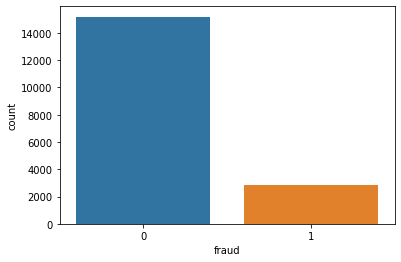

In [34]:
sns.countplot(train['fraud'])

## 3. Sampling the minority group


*   Over sampling
*   Under sampling
*   SMOTE



In [35]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [36]:
ros = RandomOverSampler(random_state=42)
rus = RandomUnderSampler(random_state=42)
smt = SMOTE(random_state=42, n_jobs=-1)

X_over, y_over = ros.fit_resample(X_train,y_train)
X_under, y_under = rus.fit_resample(X_train,y_train)
X_smote, y_smote = smt.fit_resample(X_train,y_train)

In [37]:
X_over = pd.DataFrame(X_over)
X_over.columns = X_val.columns.tolist()

In [38]:
clf = LGBMClassifier()
clf.fit(X_over, y_over)
y_pred = np.rint(clf.predict_proba(X_val)[:, 1])
f1_score(y_val, y_pred, average=None)

array([0.82973451, 0.37935484])

In [39]:
clf = LGBMClassifier()
clf.fit(X_under, y_under)
y_pred = np.rint(clf.predict_proba(X_val)[:, 1])
f1_score(y_val, y_pred, average=None)

array([0.74120407, 0.3646833 ])

In [40]:
clf = LGBMClassifier()
clf.fit(X_smote, y_smote)
y_pred = np.rint(clf.predict_proba(X_val)[:, 1])
f1_score(y_val, y_pred, average=None)

array([0.90585871, 0.16689466])

The Oversampling method improves f1_score significantly from 0.086 to 0.379. However, the SMOTE does not show good improvement as I expected. It might be because of the categorical data, so let's use SMTENC

In [41]:
cat_cols

['gender',
 'living_status',
 'claim_date',
 'claim_day_of_week',
 'accident_site',
 'channel',
 'vehicle_category',
 'vehicle_color']

In [42]:
np.argwhere(X.columns.isin(cat_cols)).ravel()

array([ 2,  8, 10, 11, 12, 16, 20, 22])

In [43]:
smtenc = SMOTENC(random_state=42, categorical_features=[ 2,  8, 10, 11, 12, 16, 20, 22])
X_smtenc, y_smtenc = smtenc.fit_resample(X_train,y_train)

clf = LGBMClassifier()
clf.fit(X_smtenc, y_smtenc)
y_pred = np.rint(clf.predict_proba(X_val)[:, 1])
f1_score(y_val, y_pred, average=None)

array([0.91175112, 0.18953324])

After consider the categorical features with SMOTENC, the f1_score still can not compete Random Over Sampling.

## 4. Hyperparameter tuning for LGBM, XGboost

Use 

In [ ]:
# !pip install mljar-supervised
from supervised.automl import AutoML

There is something wrong with imbalance libriary after install AutoML. So I create Over sampling train data from another notebook(same as previous)

In [ ]:
X_over = pd.read_csv('/content/drive/MyDrive/2021-travelers-modeling-competition/X_over.csv')
y_over = pd.read_csv('/content/drive/MyDrive/2021-travelers-modeling-competition/y_over.csv')

In [ ]:
X_over.columns = X_train.columns.tolist()

In [ ]:
X_val = pd.read_csv('/content/drive/MyDrive/2021-travelers-modeling-competition/X_val.csv')
y_val = pd.read_csv('/content/drive/MyDrive/2021-travelers-modeling-competition/y_val.csv')

In [ ]:
X_val = pd.DataFrame(X_val)

In [ ]:
automl = AutoML()
automl.fit(X_train, y_train)

predictions = automl.predict(X_val)

Linear algorithm was disabled.
AutoML directory: AutoML_1
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline logloss 0.433633 trained in 0.65 seconds
2_DecisionTree logloss 0.417234 trained in 15.87 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost logloss 0.39764 trained in 14.78 seconds
4_Default_NeuralNetwork logloss 0.40869 trained in 6.13 seconds
5_Default_RandomForest logloss 0.405727 trained in 16.19 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.394965 trained in 1.35 seconds
AutoML fit time: 76.35 seconds
AutoML best model: Ensemble


In [ ]:
f1_score(y_val, predictions, average=None)

array([0.90369207, 0.26586826])

In [ ]:
automl = AutoML(mode='Compete')
automl.fit(X_over, y_over)

predictions = automl.predict(X_val)
f1_score(y_val, predictions, average=None)

Linear algorithm was disabled.
AutoML directory: AutoML_2
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Decision Tree', 'Random Forest', 'Extra Trees', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network', 'Nearest Neighbors']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['adjust_validation', 'simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
* Step adjust_validation will try to check up to 1 model
1_DecisionTree logloss 0.650633 trained in 1.54 seconds
Adjust validation. Remove: 1_DecisionTree
Validation strategy: 10-fold CV Shuffle,Stratify
* Step simple_algorithms will try to check up to 3 models
1_DecisionTree logloss 0.65105 trained in 7.96 seconds
2_DecisionTree logloss 0.641702 trained in 8.4 seconds
3_DecisionT

array([0.91500904, 0.        ])

In [ ]:
automl = AutoML(results_path='/content/AutoML_1')
predictions = automl.predict(X_val)
f1_score(y_val, predictions, average=None)

array([0.90369207, 0.26586826])

In [ ]:
pred_val = pd.DataFrame(predictions)

In [ ]:
pred_val.value_counts()

0    3599
1       1
dtype: int64

In [ ]:
y_val.value_counts()

fraud
0        3037
1         563
dtype: int64

In [ ]:
X_smote = pd.read_csv('/content/drive/MyDrive/2021-travelers-modeling-competition/X_over.csv')
y_smote = pd.read_csv('/content/drive/MyDrive/2021-travelers-modeling-competition/y_over.csv')

In [ ]:
AutoML()

In [ ]:
automl = AutoML(results_path="AutoML_compete",
    mode='Compete',
    algorithms=["CatBoost", "Xgboost", "LightGBM"],
    model_time_limit=30*60,
    start_random_models=10,
    hill_climbing_steps=3,
    top_models_to_improve=3,
    golden_features=True,
    features_selection=False,
    stack_models=True,
    train_ensemble=True,
    explain_level=0,
    eval_metric='f1' ,
    validation_strategy={
        "validation_type": "kfold",
        "k_folds": 3,
        "shuffle": False,
        "stratify": True,
    }
)
automl.fit(X_over, y_over)

predictions = automl.predict(X_val)
f1_score(y_val, predictions, average=None)

AutoML directory: AutoML_compete
The task is binary_classification with evaluation metric f1
AutoML will use algorithms: ['CatBoost', 'Xgboost', 'LightGBM']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'hill_climbing_1', 'hill_climbing_2', 'hill_climbing_3', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 3 models
1_Default_LightGBM f1 0.963511 trained in 108.04 seconds
2_Default_Xgboost f1 0.943846 trained in 194.39 seconds
3_Default_CatBoost f1 0.929267 trained in 44.2 seconds
* Step not_so_random will try to check up to 27 models
13_LightGBM f1 0.904932 trained in 145.44 seconds
4_Xgboost f1 0.940488 trained in 103.86 seconds
22_CatBoost f1 0.956018 trained in 81.99 seconds
14_LightGBM f1 0.970984 trained in 71.29 seconds
5_Xgboost f

array([0.91484552, 0.        ])

In [ ]:
automl = AutoML(results_path='/content/AutoML_compete', algorithms='Ensemble_Stacked')
predictions = automl.predict(X_val)
f1_score(y_val, predictions, average=None)

array([0.91484552, 0.        ])

The AutoML did a bad prediction on fraud part of f1_score, however, its hyperparameter did improved 0.01 score on top of voting method. Will see it in next part.

           "model_type": "LightGBM",
            "ml_task": "binary_classification",
            "n_jobs": -1,
            "seed": 1242,
            "objective": "binary",
            "num_leaves": 31,
            "learning_rate": 0.1,
            "feature_fraction": 0.8,
            "bagging_fraction": 0.8,
            "min_data_in_leaf": 5,
            "metric": "custom",
            "custom_eval_metric_name": "f1",
            "explain_level": 0

            "params": {
                "model_type": "CatBoost",
                "ml_task": "binary_classification",
                "n_jobs": -1,
                "seed": 1238,
                "learning_rate": 0.2,
                "depth": 8,
                "rsm": 1.0,
                "loss_function": "Logloss",
                "eval_metric": "F1",
                "explain_level": 0
            },

            "params": {
                "model_type": "Xgboost",
                "ml_task": "binary_classification",
                "n_jobs": -1,
                "seed": 1240,
                "objective": "binary:logistic",
                "eta": 0.1,
                "max_depth": 4,
                "min_child_weight": 25,
                "subsample": 0.7,
                "colsample_bytree": 0.7,
                "eval_metric": "f1",
                "explain_level": 0
            },

## 5.Ensamble methods

*   Voting
*   Stacking



###5.1 Voting


*   Soft voting 
*   Hard Voting



In [44]:
#XGB
clf_xgb = XGBClassifier()
#LGBM
clf_lgb = LGBMClassifier()
#CatBoost
clf_cat = CatBoostClassifier(verbose=False)


clf_soft = VotingClassifier(estimators=[('cat', clf_cat), ('xgb', clf_xgb), ('lgb', clf_lgb)], voting='soft')
clf_soft = clf_soft.fit(X_over,y_over)
y_pred_soft = np.rint(clf_soft.predict_proba(X_val)[:, 1])
# y_pred_soft 
f1_score(y_val, y_pred_soft, average=None)

array([0.8354163 , 0.38446346])

In [45]:
#XGB
clf_xgb = XGBClassifier()
#LGBM
clf_lgb = LGBMClassifier()


clf_soft = VotingClassifier(estimators=[('xgb', clf_xgb), ('lgb', clf_lgb)], voting='soft')
clf_soft = clf_soft.fit(X_over,y_over)
y_pred_soft = np.rint(clf_soft.predict_proba(X_val)[:, 1])
# y_pred_soft 
f1_score(y_val, y_pred_soft, average=None)

array([0.80996545, 0.3856555 ])

In [46]:
#XGB
clf_xgb = XGBClassifier()
#LGBM
clf_lgb = LGBMClassifier()
#CatBoost
clf_cat = CatBoostClassifier(verbose=False)


clf_soft = VotingClassifier(estimators=[('cat', clf_cat), ('xgb', clf_xgb), ('lgb', clf_lgb)], voting='hard')
clf_soft = clf_soft.fit(X_over,y_over)
y_pred_hard = (clf_soft.predict(X_val))
# y_pred_soft 
f1_score(y_val, y_pred_hard, average=None)

array([0.82961389, 0.38095238])

In [47]:
#XGB
clf_xgb = XGBClassifier()
#LGBM
clf_lgb = LGBMClassifier()


clf_soft = VotingClassifier(estimators=[ ('xgb', clf_xgb), ('lgb', clf_lgb)], voting='hard')
clf_soft = clf_soft.fit(X_over,y_over)
y_pred_hard = (clf_soft.predict(X_val))
# y_pred_soft 
f1_score(y_val, y_pred_hard, average=None)

array([0.84111498, 0.37534247])

Soft voting with two models (XBG+LGBM) got the best f1 score: 0.385

In [49]:
#XGB
clf_xgb = XGBClassifier(objective='binary:logistic', n_jobs=-1, seed=1240, eta=0.1, max_depth=4, min_child_weight=25, subsample=0.7, colsample_bytree=0.7, best_ntree_limit=64)
#LGBM
clf_lgb = LGBMClassifier(n_jobs=-1, objective='binary', num_leaves=63, learning_rate=0.035, feature_fraction=0.9, bagging_fraction=0.9, min_data_in_leaf=10)


clf_soft = VotingClassifier(estimators=[('xgb', clf_xgb), ('lgb', clf_lgb)], voting='soft')
clf_soft = clf_soft.fit(X_over,y_over)
y_pred_soft = np.rint(clf_soft.predict_proba(X_val)[:, 1])
# y_pred_soft 
f1_score(y_val, y_pred_soft, average=None)

array([0.81171548, 0.39224897])

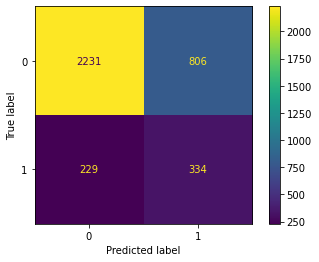

In [50]:
plot_confusion_matrix(clf_soft, X_val, y_val, values_format='d')

Use Random Over Sampling + soft Voting(XGB+LGBM) + Hyperparameter tuning improve f1_score to 0.392

###5.2 Stacking

In [ ]:
#XGB
clf_xgb = XGBClassifier(objective='binary:logistic', n_jobs=-1, seed=1240, eta=0.1, max_depth=4, min_child_weight=25, subsample=0.7, colsample_bytree=0.7, best_ntree_limit=64)
#LGBM
clf_lgb = LGBMClassifier(n_jobs=-1, objective='binary', num_leaves=63, learning_rate=0.035, feature_fraction=0.9, bagging_fraction=0.9, min_data_in_leaf=10)
#CatBoost
clf_cat = CatBoostClassifier()

clf_stack = StackingClassifier(estimators=[('xgb', clf_xgb)], final_estimator=clf_lgb)
clf_stack = clf_stack.fit(X_over,y_over)
y_pred_stack = clf_stack.predict(X_val)
f1_score(y_val, y_pred_stack, average=None)

array([0.78679351, 0.37846656])

In [ ]:
#XGB
clf_xgb = XGBClassifier(objective='binary:logistic', n_jobs=-1, seed=1240, eta=0.1, max_depth=4, min_child_weight=25, subsample=0.7, colsample_bytree=0.7, best_ntree_limit=64)
#LGBM
clf_lgb = LGBMClassifier(n_jobs=-1, objective='binary', num_leaves=63, learning_rate=0.035, feature_fraction=0.9, bagging_fraction=0.9, min_data_in_leaf=10)
#CatBoost
# clf_cat = CatBoostClassifier(verbose=False)

clf_stack = StackingClassifier(estimators=[('lgb', clf_lgb), ('xgb', clf_xgb)], final_estimator=clf_lgb)
clf_stack = clf_stack.fit(X_over,y_over)
y_pred_stack = clf_stack.predict(X_val)
f1_score(y_val, y_pred_stack, average=None)




array([0.8463136 , 0.37552743])

In [ ]:
from mlxtend.classifier import StackingCVClassifier 
from sklearn.neural_network import MLPClassifier
#XGB
clf_xgb = XGBClassifier(objective='binary:logistic', n_jobs=-1, seed=1240, eta=0.1, max_depth=4, min_child_weight=25, subsample=0.7, colsample_bytree=0.7, best_ntree_limit=64)
#LGBM
clf_lgb = LGBMClassifier(n_jobs=-1, objective='binary', num_leaves=63, learning_rate=0.035, feature_fraction=0.9, bagging_fraction=0.9, min_data_in_leaf=10)
#CatBoost
clf_cat = CatBoostClassifier(verbose=False)

# Initializing Multi-layer perceptron  classifier
clf_mlp = MLPClassifier(activation = "relu", alpha = 0.1, hidden_layer_sizes = (100,100,100),
                            learning_rate = "constant", max_iter = 2000, random_state = 1000)

# Initializing the StackingCV classifier
sclf = StackingCVClassifier(classifiers = [clf_xgb, clf_lgb, clf_cat],
                            shuffle = False,
                            use_probas = True,
                            cv = 10,
                            meta_classifier = clf_mlp)

# Create list to store classifiers
classifiers = {"xgb": clf_xgb,
               "lgb": clf_lgb,
               "Stack": sclf}

# Train classifiers
for key in classifiers:
    # Get classifier
    classifier = classifiers[key]
    
    # Fit classifier
    classifier.fit(X_over.to_numpy(), y_over)
        
    # Save fitted classifier
    classifiers[key] = classifier

# Get results
results = pd.DataFrame()
for key in classifiers:
    # Make prediction on test set
    y_pred = classifiers[key].predict_proba(X_val.to_numpy())[:,1]
    
    # Save results in pandas dataframe object
    results[f"{key}"] = y_pred

# Add the test set to the results object
# results["Target"] = y_val
f1_score(y_val, np.rint(results['Stack']), average=None)

array([0.89607535, 0.20240964])

Stacking method fails to beat soft voting method even adding deep learning models

##6. Feature Engineering & EDA

It may because of lacking of domain knowledge, I use different kinds of FE methods to try to reveal more infomation to the models, but failed. The best score I got in kaggle is 0.3966 for the test data. Below are the EDA and FE I explored:

In [ ]:
def ohec(df1,df2, feature1):
  ohec = OneHotEncoder()
  data = pd.concat([df1, df2])
  flist = data[feature1].unique() 
  new_col = [] # create new columns name list 
  for f in flist:
    cn = feature1 + "_" + f
    new_col.append(cn)
  df1[new_col] = ohec.fit_transform(df1[[feature1]]).toarray()
  df1[new_col] = df1[new_col].astype(int)
  df2[new_col] = ohec.fit_transform(df2[[feature1]]).toarray()
  df2[new_col] = df2[new_col].astype(int)
  df1 = df1.drop(columns=feature1, axis=1)
  df2 = df2.drop(columns=feature1, axis=1)


In [ ]:
ohec(train,test, 'claim_day_of_week')

In [ ]:
ohec(train,test, 'accident_site')

In [ ]:
ohec(train,test, 'channel')

In [ ]:
ohec(train,test, 'vehicle_category')

In [ ]:
ohec(train,test, 'vehicle_color')

In [ ]:
train.select_dtypes(include=['object', 'category']).columns

Index(['gender', 'living_status', 'claim_date', 'claim_day_of_week',
       'accident_site', 'channel', 'vehicle_category', 'vehicle_color'],
      dtype='object')

In [ ]:
train = train.drop(columns=['claim_day_of_week','accident_site', 'channel', 'vehicle_category', 'vehicle_color'], axis=1)

In [ ]:
test = test.drop(columns=['claim_day_of_week','accident_site', 'channel', 'vehicle_category', 'vehicle_color'], axis=1)

Zipcode

In [ ]:
! pip install uszipcode

In [ ]:
# map zipcode to state 
from uszipcode import SearchEngine, SimpleZipcode, Zipcode
search = SearchEngine()

def zco(x):
    state = search.by_zipcode(x).state
    return state if state else 'None'

train['state'] = train['zip_code'].apply(zco)
test['state'] = test['zip_code'].apply(zco)

Start downloading data for simple zipcode database, total size 9MB ...
  1 MB finished ...
  2 MB finished ...
  3 MB finished ...
  4 MB finished ...
  5 MB finished ...
  6 MB finished ...
  7 MB finished ...
  8 MB finished ...
  9 MB finished ...
  10 MB finished ...
  Complete!


In [ ]:
# map zipcode to major city
from uszipcode import SearchEngine, SimpleZipcode, Zipcode
search = SearchEngine()

def zco_city(x):
    city = search.by_zipcode(x).major_city
    return city if city else 'None'

train['city'] = train['zip_code'].apply(zco_city)
test['city'] = test['zip_code'].apply(zco_city)

Exception ignored in: <function SearchEngine.__del__ at 0x7fe7981e64d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/uszipcode/search.py", line 127, in __del__
  File "/usr/local/lib/python3.7/dist-packages/uszipcode/search.py", line 133, in close
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/orm/session.py", line 1786, in close
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/orm/session.py", line 1828, in _close_impl
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/orm/session.py", line 923, in close
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/engine/base.py", line 2315, in close
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/engine/base.py", line 2531, in _do_close
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/engine/base.py", line 2517, in _close_impl
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/engine/base.py", line 2509, in _connection_rollback_impl
  File "/usr/lo

In [ ]:
# map zipcode to state and major city
from uszipcode import SearchEngine, SimpleZipcode, Zipcode
search = SearchEngine()

def zco_county(x):
    county = search.by_zipcode(x).county
    return county if county else 'None'

train['county'] = train['zip_code'].apply(zco_county)
test['county'] = test['zip_code'].apply(zco_county)

Exception ignored in: <function SearchEngine.__del__ at 0x7fe7981e64d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/uszipcode/search.py", line 127, in __del__
  File "/usr/local/lib/python3.7/dist-packages/uszipcode/search.py", line 133, in close
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/orm/session.py", line 1786, in close
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/orm/session.py", line 1828, in _close_impl
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/orm/session.py", line 923, in close
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/engine/base.py", line 2315, in close
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/engine/base.py", line 2531, in _do_close
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/engine/base.py", line 2517, in _close_impl
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/engine/base.py", line 2509, in _connection_rollback_impl
  File "/usr/lo

Holiday

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
dr = pd.date_range(start='2015-01-01', end='2016-12-31')


cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max(), return_name=True)

train['Holiday'] =train['claim_date'].apply(lambda x: holidays.get(x))
test['Holiday'] =test['claim_date'].apply(lambda x: holidays.get(x))

train['Holiday'] = train['Holiday'].fillna('Workday')
test['Holiday'] = test['Holiday'].fillna('Workday')

In [ ]:
ohec(train,test, 'Holiday')

In [ ]:
train = train.drop(columns=['Holiday'], axis=1)
test = test.drop(columns=['Holiday'], axis=1)

In [ ]:
train.select_dtypes(include=['object', 'category']).columns

Index(['gender', 'living_status', 'claim_date', 'state', 'city', 'county'], dtype='object')

In [ ]:
train['zip_code'].nunique()

276

Frequency encoding

In [ ]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')

In [ ]:
encode_FE(train, test, ['state', 'zip_code', 'claim_date', 'city', 'county'])

state_FE , zip_code_FE , claim_date_FE , city_FE , county_FE , 

In [ ]:
def cat2num (cols_list):
  for col in cols_list:
    le = LabelEncoder()
    le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
    train[col] = le.transform(list(train[col].astype(str).values))
    test[col] = le.transform(list(test[col].astype(str).values))

In [ ]:
cols_list = train.select_dtypes(include=['object', 'category']).columns.tolist()
cat2num(cols_list)

In [ ]:
X, y = train.drop(columns='fraud', axis=1), train.fraud
# X = X.drop(columns='claim_number', axis=1)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [ ]:
ros = RandomOverSampler(random_state=42)
rus = RandomUnderSampler(random_state=42)
smt = SMOTE(random_state=42, n_jobs=-1)

X_under, y_under = rus.fit_sample(X_train,y_train)
X_over, y_over = ros.fit_sample(X_train,y_train)
X_smote, y_smote = smt.fit_sample(X_train,y_train)

In [ ]:
X_over = pd.DataFrame(X_over)
X_over.columns = X.columns.tolist()

In [ ]:
#XGB
clf_xgb = XGBClassifier(objective='binary:logistic', n_jobs=-1, seed=1240, eta=0.1, max_depth=4, min_child_weight=25, subsample=0.7, colsample_bytree=0.7, best_ntree_limit=64)
#LGBM
clf_lgb = LGBMClassifier(n_jobs=-1, objective='binary', num_leaves=63, learning_rate=0.035, feature_fraction=0.9, bagging_fraction=0.9, min_data_in_leaf=10)
#CatBoost
clf_cat = CatBoostClassifier()

clf_soft = VotingClassifier(estimators=[('xgb', clf_xgb), ('lgb', clf_lgb)], voting='soft')
clf_soft = clf_soft.fit(X_over,y_over)
y_pred_soft = np.rint(clf_soft.predict_proba(X_val)[:, 1])
# y_pred_soft 
f1_score(y_val, y_pred_soft, average=None)

array([0.81339367, 0.38447761])

In [ ]:
#XGB
clf_xgb = XGBClassifier()
#LGBM
clf_lgb = LGBMClassifier()
#CatBoost
clf_cat = CatBoostClassifier()

clf_soft = VotingClassifier(estimators=[('xgb', clf_xgb), ('lgb', clf_lgb)], voting='soft')
clf_soft = clf_soft.fit(X_over,y_over)
y_pred_soft = np.rint(clf_soft.predict_proba(X_val)[:, 1])
# y_pred_soft 
f1_score(y_val, y_pred_soft, average=None)

array([0.81291962, 0.38957963])

In [ ]:
clf = LGBMClassifier()
clf.fit(X_over, y_over)
y_pred = np.rint(clf.predict_proba(X_val)[:, 1])
f1_score(y_val, y_pred, average=None)

array([0.82874294, 0.36848958])

In [ ]:
importance= pd.DataFrame()
importance["Features"] = X.columns
importance["Score"] = clf.feature_importances_

fs_after = importance[importance['Score']>0]['Features'].tolist()
fs_remove = importance[importance['Score']==0]['Features'].tolist()

In [ ]:
train = train.drop(columns=fs_remove, axis=1)
test = test.drop(columns=fs_remove, axis=1)

In [ ]:
train.to_csv('train_FE11.csv', index=False)
!cp train_FE11.csv "/content/drive/MyDrive/2021-travelers-modeling-competition/"
test.to_csv('test_FE11.csv', index=False)
!cp test_FE11.csv "/content/drive/MyDrive/2021-travelers-modeling-competition/"

In [ ]:
importance.sort_values(by = "Score", ascending=False).head(60)

,Features,Score
15,claim_est_payout,220
0,claim_number,199
17,vehicle_price,196
4,safty_rating,186
5,annual_income,178
18,vehicle_weight,178
10,claim_date,167
13,liab_prct,159
9,zip_code,147
59,claim_date_FE,124
